In [1]:
import pandas as pd

In [2]:
pandas_df = pd.read_csv('C:/Users/hedin/Documents/pyspark-the correct way/notebooks/diabetes.csv')
pandas_df = pandas_df.loc[(pandas_df['Glucose'] != 0)
& (pandas_df['BloodPressure'] != 0)
& (pandas_df['BMI'] != 0),
['Pregnancies',
'Glucose',
'BloodPressure',
'BMI',
'DiabetesPedigreeFunction',
'Age',
'Outcome'
]]

In [3]:
#import the libs for the analisis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [5]:
#define the feature and target columns
x_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
          'DiabetesPedigreeFunction', 'Age']
x = pandas_df[x_cols]
y = pandas_df["Outcome"]

In [6]:
#standarize the features using the standardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [7]:
#define a list of classifiers
classifiers = [LogisticRegression(), DecisionTreeClassifier(),
               RandomForestClassifier(), LinearSVC(max_iter=1500)]

In [15]:
#use a for-loop to perform ten-fold cross-validation
for classifier in classifiers:
    result = cross_val_score(
        classifier,
        x_scaled,
        y,
        cv=10,
        scoring="roc_auc"
    )
    print(
        f"{classifier.__class__.__name__} "
        f"mean: {result.mean():.2f}"
    )


LogisticRegression mean: 0.84
DecisionTreeClassifier mean: 0.68
RandomForestClassifier mean: 0.82
LinearSVC mean: 0.84


In [17]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

In [18]:
#define the decision tree and random forest models

decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()


In [19]:
y_scores_decision_tree = cross_val_predict(
    decision_tree_model,
    x,
    y,
    cv=10,
    method="predict_proba"
)

y_scores_random_forest = cross_val_predict(
    random_forest_model,
    x,
    y,
    cv=10,
    method="predict_proba"
)

In [20]:
#calculate roc curves and aucs for the models
fpr_decision_tree, tpr_decision_tree, _ = roc_curve(y,
y_scores_decision_tree[:, 1])
roc_auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)
fpr_random_forest, tpr_random_forest, _ = roc_curve(y,
y_scores_random_forest[:, 1])
roc_auc_random_forest = auc(fpr_random_forest, tpr_random_forest)

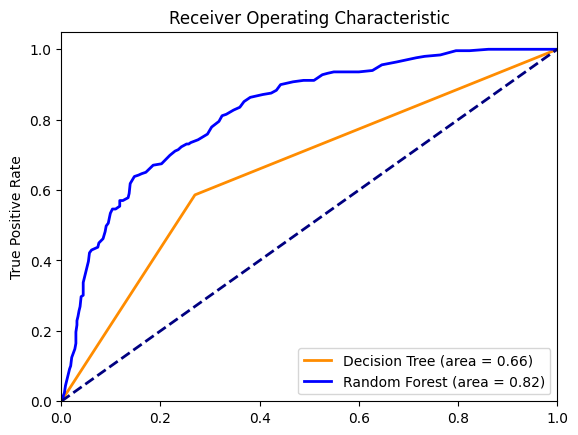

In [21]:
#plot roc curves
plt.figure()
plt.plot(fpr_decision_tree, tpr_decision_tree, color='darkorange',
lw=2, label='Decision Tree (area = %0.2f)' % roc_auc_decision_tree)
plt.plot(fpr_random_forest, tpr_random_forest, color='blue', lw=2,
label='Random Forest (area = %0.2f)' % roc_auc_random_forest)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("diabetes_data") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .master("local[*]") \
    .getOrCreate()


In [38]:
spark_df = spark.read.csv('C:/Users/hedin/Documents/pyspark-the correct way/notebooks/diabetes.csv',header=True, inferSchema=True)
spark_df = spark_df.filter((col('Glucose') != 0)
                         & (col('BloodPressure') != 0)
                         & (col('BMI') != 0)) \
                         .select(['Pregnancies',
                            'Glucose',
                            'BloodPressure',
                            'BMI',
                            'DiabetesPedigreeFunction',
                            'Age',
                            'Outcome'])

In [34]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [35]:
#combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=[
          'Pregnancies',
          'Glucose',
          'BloodPressure',
          'BMI',
          'DiabetesPedigreeFunction',
          'Age', ], outputCol="features")

In [40]:
data = assembler.transform(spark_df)

In [41]:
data.show(5, truncate=False)

+-----------+-------+-------------+----+------------------------+---+-------+--------------------------------+
|Pregnancies|Glucose|BloodPressure|BMI |DiabetesPedigreeFunction|Age|Outcome|features                        |
+-----------+-------+-------------+----+------------------------+---+-------+--------------------------------+
|6          |148    |72           |33.6|0.627                   |50 |1      |[6.0,148.0,72.0,33.6,0.627,50.0]|
|1          |85     |66           |26.6|0.351                   |31 |0      |[1.0,85.0,66.0,26.6,0.351,31.0] |
|8          |183    |64           |23.3|0.672                   |32 |1      |[8.0,183.0,64.0,23.3,0.672,32.0]|
|1          |89     |66           |28.1|0.167                   |21 |0      |[1.0,89.0,66.0,28.1,0.167,21.0] |
|0          |137    |40           |43.1|2.288                   |33 |1      |[0.0,137.0,40.0,43.1,2.288,33.0]|
+-----------+-------+-------------+----+------------------------+---+-------+--------------------------------+
o

In [42]:
data = data.withColumnRenamed("Outcome", "label")

In [43]:
#standardize the feature columns
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
data = scaler.fit(data).transform(data)

In [44]:
#define a list of classification models
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LinearSVC(maxIter=1500)]
#build an empty parameter grid
paramGrid = ParamGridBuilder().build()

In [46]:
#define a binaryclassificationevaluator
evaluator = BinaryClassificationEvaluator(labelCol="label",
          rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [48]:
#for each classifier in the list of classifiers
for classifier in classifiers:
    cv = CrossValidator(
        estimator=classifier, estimatorParamMaps=paramGrid,
        evaluator=evaluator, numFolds=10
    )
    cvModel = cv.fit(data)
    results = cvModel.transform(data)
    accuracy = evaluator.evaluate(results)
    print(f"{classifier.__class__.__name__} mean: {accuracy:.2f}")


LogisticRegression mean: 0.84
DecisionTreeClassifier mean: 0.78
RandomForestClassifier mean: 0.91
LinearSVC mean: 0.84
